# House price data exploration

Utilizing several tutorials, kernals on Kaggle:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques#tutorials
Typed, not forked or pasted to improve learning.        


### Import libraries

In [312]:
import sys
sys.path.insert(0, "//anaconda/envs/cdips2017/bin/python")  # Fix for Wyatt's Desktop

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [326]:
# import data and inspect contents
housesT = pd.read_csv('train.csv')
houses_test = pd.read_csv('test.csv')
housesT.shape
housesT.columns

# distinguish categorical and numerical features
categorical= houses.select_dtypes(include = ["object"]).columns
numeric = houses.select_dtypes(exclude = ["object"]).columns

# Split DS by feature type
housesT_cat = housesT[categorical]  # housesT_cat.head()
housesT_num = housesT[numeric] # housesT_num.head()

## Initial data exploration

##### Which variables are correlated with Price,  and how are they clustered?

Cannot apply below to categorical variables until they are cleaned/transformed

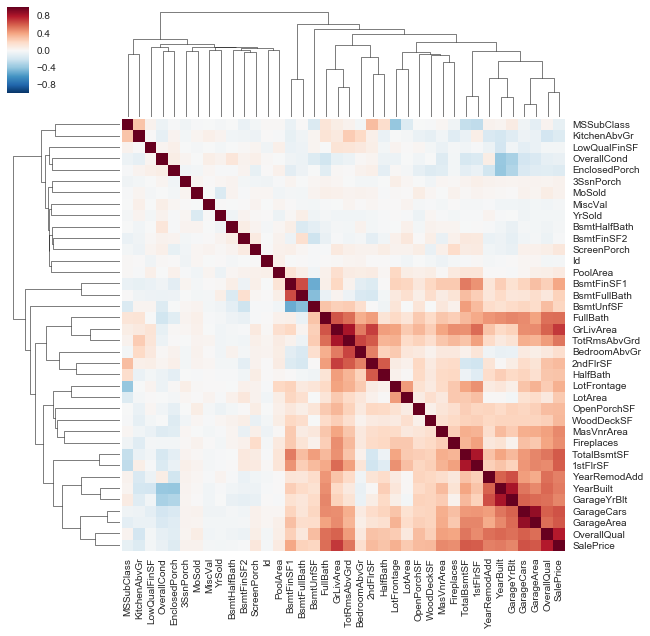

In [344]:
# heatmap style, does corr() filter by p-value?
corrmatT = housesT_num.corr()
#f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=1, square=True);

cm = sns.clustermap(corrmatT, vmin=-1, vmax=1)
plt.sca(cm.ax_heatmap) # More on this in a minute
plt.yticks(rotation=0);

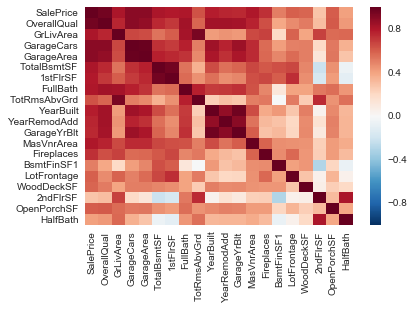

In [276]:
# Method 2: filter corrmat by variable, cut number
k = 20 # number of variables for heatmap
#corrmat = df_train.corr()
cols = corrmatT.nlargest(k, 'SalePrice')['SalePrice'].index 
pos = corrmatT.nlargest(k, 'SalePrice')['SalePrice'].index 
neg = corrmatT.nsmallest(k, 'SalePrice')['SalePrice'].index 

cmP = np.corrcoef(corrmatT[pos].values.T)
cmN = np.corrcoef(corrmatT[neg].values.T)
sns.heatmap(cmP, yticklabels=pos.values, xticklabels=pos.values)
# sns.heatmap(cmN, yticklabels=neg.values, xticklabels=neg.values)

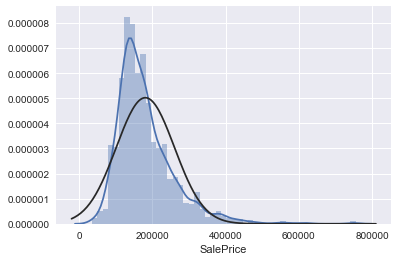

In [250]:
# Check data distribution of response var
sns.distplot(housesT['SalePrice'], fit=norm);

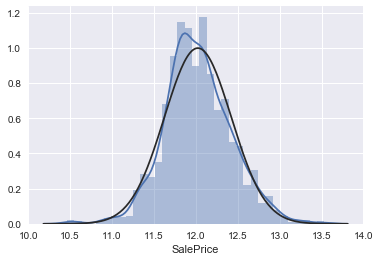

In [251]:
# Log transform and replot, log is close...
housesT['SalePrice'] = np.log(housesT['SalePrice'])
sns.distplot(housesT['SalePrice'], fit=norm);

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath',
       'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr'],
      dtype='object')

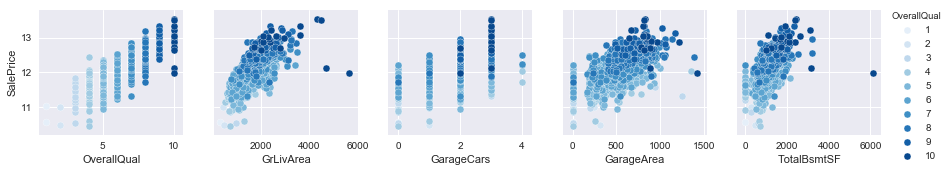

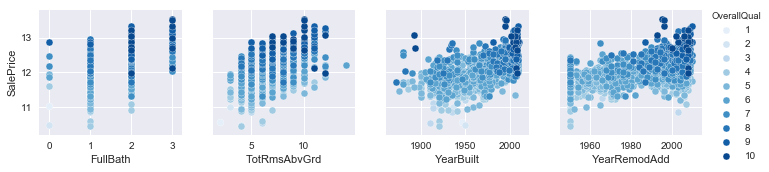

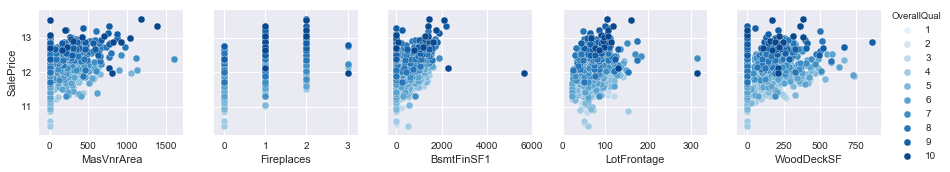

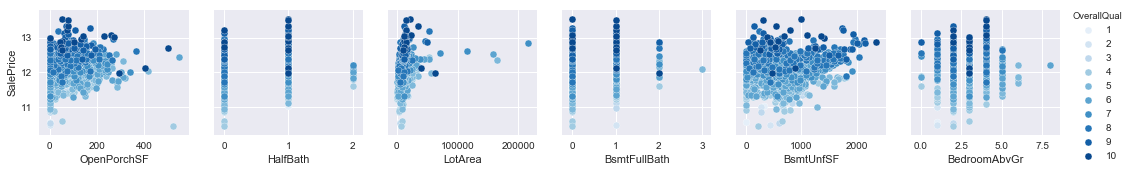

In [256]:
pos = corrmatT.nlargest(24, 'SalePrice')['SalePrice'].index 

f,axarr = plt.subplots(1,,sharey='row',figsize=(16,7))
sns.pairplot(y_vars=["SalePrice"], x_vars = pos[1:6], hue='OverallQual', palette='Blues', data=housesT) 
sns.pairplot(y_vars=["SalePrice"], x_vars = pos[7:11], hue='OverallQual', palette='Blues', data=housesT)
sns.pairplot(y_vars=["SalePrice"], x_vars = pos[12:17], hue='OverallQual', palette='Blues', data=housesT)
sns.pairplot(y_vars=["SalePrice"], x_vars = pos[18:24], hue='OverallQual', palette='Blues', data=housesT)

#sns.pairplot(vars=['SalePrice', 'YearBuilt', 'GrLivArea', 'GarageCars'], hue='OverallQual', data=housesT)
# plt.subplots_adjust(right=.85)
pos

## Minimalist Feature engineering

simple data processing copied from https://www.kaggle.com/apapiu/regularized-linear-models

In [338]:
# find skewed features, log transform
numeric_feats = housesT.dtypes[housesT.dtypes != "object"].index

skewed_feats = housesT[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

housesT[skewed_feats] = np.log1p(housesT[skewed_feats])

In [341]:
# Get dummy variables for categoricals
housesT = pd.get_dummies(housesT)
housesT.shape


(1460, 290)

In [342]:
#filling NA's with the mean of the column:
#all_data = all_data.fillna(all_data.mean())

X_train = housesT[:housesT.shape[0]]
X_test = houses_test[houses_test.shape[0]:]
y = housesT.SalePrice

## Models

In [346]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import preprocessing

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
Partition into training and test sets:

In [343]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(housesT.drop('logSalePrice',1), train_test_split(houses_test.drop('logSalePrice',1),housesT['logSalePrice'], test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

SyntaxError: invalid syntax (<ipython-input-343-74bdd9e5e037>, line 3)

#### Ridge regression

In [333]:
model_ridge = Ridge()

# Tuning parameters: Alpha is regularization parameter
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

ValueError: could not convert string to float: 'Normal'

In [ ]:
# Cross val of alpha
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

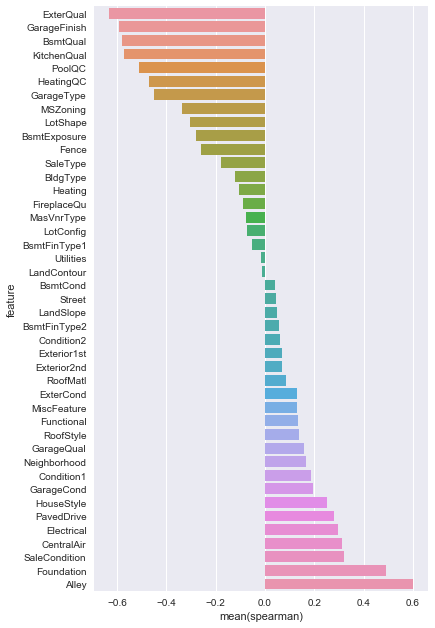

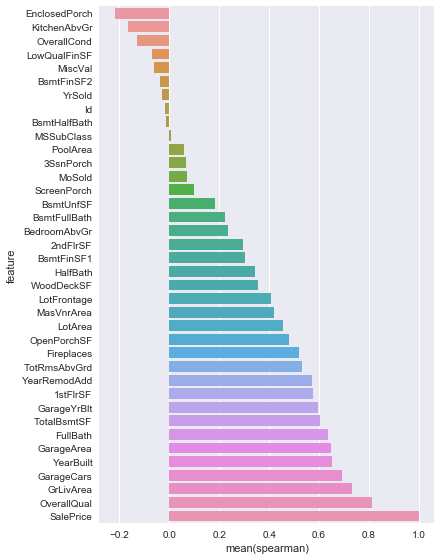

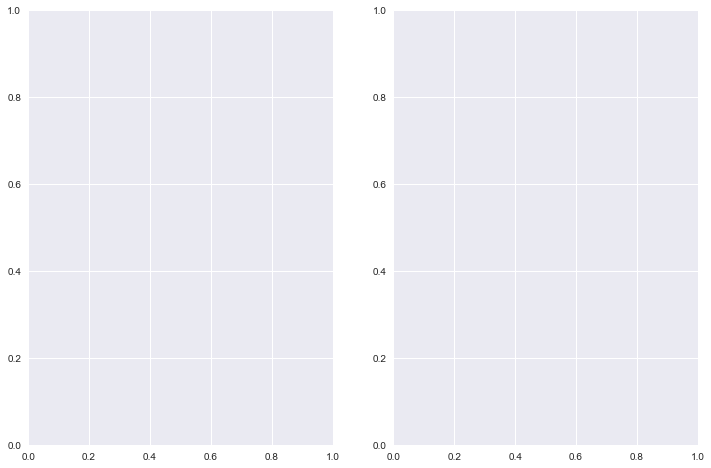

In [50]:
def spearman(frame, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
#features = categorical, numeric
spearman(housesT, housesT_cat)
spearman(housesT, housesT_num)

fig = plt.figure(figsize=(12, 8)) # Create a new figure
ax1 = plt.subplot(1, 2, 1) # Create a subplot (returns an axes)
ax2 = plt.subplot(1, 2, 2) # Create the other subplot (returns an axes)



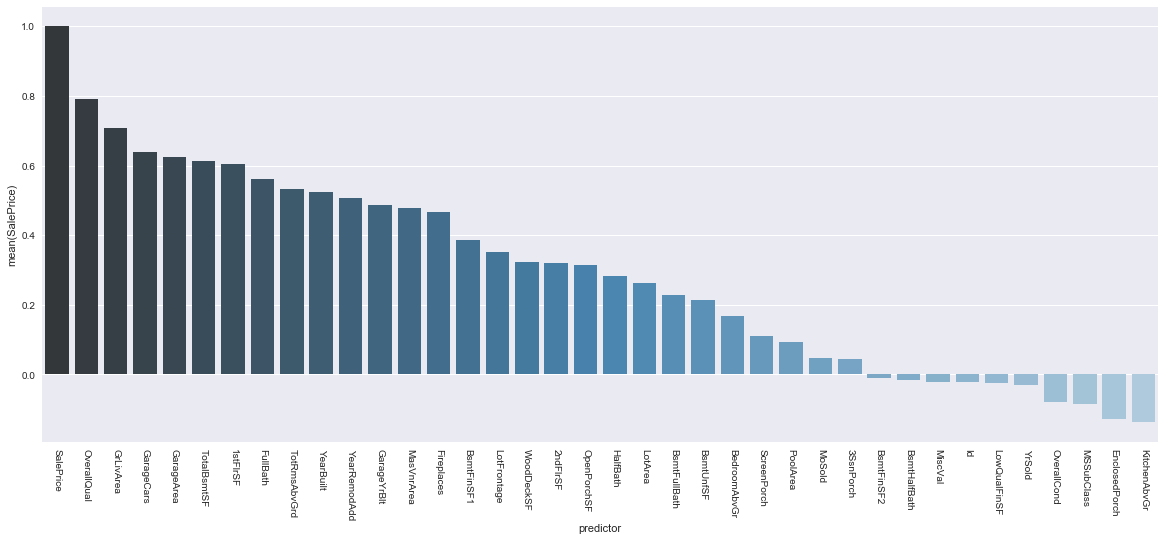

In [339]:
# Method 1: strip column from corrmat
# corrmatT.head()

ct = corrmatT[['SalePrice']].copy()  # extract data # print(type(ct))
#srt = ct.sort_values('SalePrice')    # srt.head() #srt
srt = ct.sort_values('SalePrice', ascending = False)  

# Add back rownames as var --not needed for plt, but appears needed for sns
srt.index.name = 'predictor'
srt.reset_index(inplace=True)

# Plot sns barplot
fig = plt.figure(figsize=(20,8)) # Create a new figure
sns.barplot(y='SalePrice', x='predictor', data=srt, palette="Blues_d")
plt.xticks(rotation=270)

# Choose k most significant values
pos = corrmatT.nlargest(k, 'SalePrice')['SalePrice'].index 
cmP = np.corrcoef(corrmatT[pos].values.T)
# predictrs = srt(:,1)
# DFpos= pd.DataFrame(cmP, index=srt("predictor"), columns=srt("predictor"))
# srt("predictor")
# DFpos.head()
# cmP
#srt.head()

In [ ]:
# Method 2: filter corrmat by variable, cut number
k = 20 # number of variables for heatmap
#corrmat = df_train.corr()
cols = corrmatT.nlargest(k, 'SalePrice')['SalePrice'].index 
pos = corrmatT.nlargest(k, 'SalePrice')['SalePrice'].index 
neg = corrmatT.nsmallest(k, 'SalePrice')['SalePrice'].index 

cmP = np.corrcoef(corrmatT[pos].values.T)
sns.heatmap(cmP, yticklabels=pos.values, xticklabels=pos.values)

# cmN = np.corrcoef(corrmatT[neg].values.T)
# sns.heatmap(cmN, yticklabels=neg.values, xticklabels=neg.values)


# cols = pos + neg
# cols = list(merge(pos, neg))
# cols = map("".join,zip(pos,neg))
# cols
#pos
#neg
#corrmatT.head()

#print(type(pos))
#print(type(cols))

#cm = corrmat[pos]
#cm.head()

# cm = np.corrcoef(corrmatT[cols].values.T)
#cm = np.corrcoef(corrmatT[cols].values.T)
# cm
#sns.heatmap(cm, yticklabels=cols.values, xticklabels=cols.values)

# plt.sca(cm.ax_heatmap) # More on this in a minute
# plt.yticks(rotation=0);